In [6]:
# Tutorial code of 1-D GAN
# http://blog.naver.com/atelierjpro/220984758512
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf


In [34]:
sess = tf.InteractiveSession()

class GenerativeNetwork:
    dim_z=1
    dim_g=1
    
    def __init__(self):
        rand_uni = tf.random_uniform_initializer(-1e1,1e1)
        self.z_input = tf.placeholder(tf.float32,shape = [None,self.dim_z],name = "z-input")
        self.W0 = tf.Variable(rand_uni([self.dim_z,self.dim_g]))
        self.b0 = tf.Variable(rand_uni([self.dim_g]))
        self.g = tf.nn.sigmoid(tf.matmul(self.z_input,self.W0)+self.b0)
        
    def generate(self,z_i):
        z_i = np.reshape(z_i,[-1,self.dim_z])
        g_i = sess.run([self.g],feed_dict={self.z_input : z_i})
        return g_i[0]


class Discriminator:
    dim_x = 1
    dim_d = 1
    num_hidden_neurons = 10
    learning_rate = 0.1
    
    def __init__(self):
        self.x_input = tf.placeholder(tf.float32,shape=[None,self.dim_x],name="x_input")
        self.d_target = tf.placeholder(tf.float32,shape=[None,self.dim_d],name="d_target")
        
        rand_uni = tf.random_uniform_initializer(-1e-2,1e-2)
        
        self.W0 = tf.Variable(rand_uni([self.dim_x,self.num_hidden_neurons]))
        self.b0 = tf.Variable(rand_uni([self.num_hidden_neurons]))
        self.W1 = tf.Variable(rand_uni([self.num_hidden_neurons,self.dim_d]))
        self.b1 = tf.Variable(rand_uni([self.dim_d]))
        
        temp = tf.nn.sigmoid(tf.matmul(self.x_input,self.W0)+self.b0)
        self.d = tf.nn.sigmoid(tf.matmul(temp,self.W1)+self.b1)
        
        self.loss = tf.losses.mean_squared_error(self.d,self.d_target)
        
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def discriminate(self,x_i):
        d_i = sess.run([self.d],feed_dict={self.x_input:x_i})
        return d_i[0]
    
    def train(self,x_i,d_i):
        error,_ = sess.run([self.loss,self.opt],feed_dict={self.x_input:x_i,self.d_target:d_i})
        return error
        

Hello! GAN!
0.149216
0.409377
0.000862018
0.000934904
0.000284792
0.00030562
0.000150692
0.000160114
9.59333e-05
0.000100933
6.74618e-05
7.02773e-05
5.04791e-05
5.20598e-05
3.94049e-05
4.02262e-05
3.17168e-05
3.20437e-05
2.61262e-05
2.6118e-05


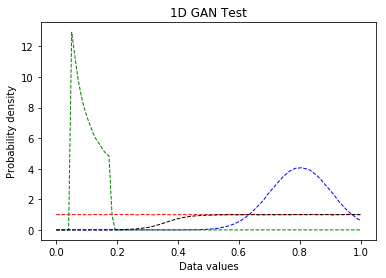

In [39]:
print("Hello! GAN!")
mu = 0.8
sigma=0.1
num_bins = 100
num_samples = 1000000

x = np.random.normal(mu,sigma,num_samples)
z = np.random.uniform(0,1,num_samples)
g = np.ndarray(num_samples)

G = GenerativeNetwork()
D = Discriminator()

tf.global_variables_initializer().run()

# for i in range(0,num_samples,1):
#     z_i = np.reshape(z[i],G.dim_z)
#     g[i] =G.generate(z_i)
x_i = np.reshape(x,(num_samples,D.dim_x))
z_i = np.reshape(z,(num_samples,G.dim_z))
g_i = G.generate(z_i)
g = np.reshape(g_i,(num_samples))

d_x_i = np.ndarray(shape=(num_samples,D.dim_x))
d_x_i.fill(1.0)

d_g_i = np.ndarray(shape = (num_samples,D.dim_x))
d_g_i.fill(0.0)

# Not a good way to train.
# TODO: shuffle samples
for tr in range(0,1000,1):
    D.train(x_i,d_x_i)
    D.train(g_i,d_g_i)
    if tr % 100 ==0:
        print(D.train(x_i,d_x_i))
        print(D.train(g_i,d_g_i))

bins = np.linspace(0,1,num_bins)
px, _ = np.histogram(x,bins=bins, density = True)
pz, _ = np.histogram(z,bins=bins, density = True)
pg,_ = np.histogram(g,bins=bins, density= True)

v = np.linspace(0,1,len(px))

v_i = np.reshape(v,(len(v),D.dim_x))
db = D.discriminate(v_i)
db = np.reshape(db,len(v))

l = plt.plot(v,px,'b--',linewidth=1)
l = plt.plot(v,pz,'r--',linewidth=1)
l = plt.plot(v,pg,'g--',linewidth=1)
l = plt.plot(v,db,'k--',linewidth=1)


plt.title('1D GAN Test')
plt.xlabel('Data values')
plt.ylabel('Probability density')
plt.show()
